<a href="https://colab.research.google.com/github/StevenVuong/MSc_Project/blob/master/p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook aims to bring together the df and loaded files to implement them in a Deep Learning Model**

In [13]:
!pip install talos

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pickle
from sklearn.model_selection import train_test_split
import nibabel as nb
import seaborn as sns

In [0]:
# imports for keras model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils, generic_utils
from keras.layers import LeakyReLU

# imports for automated parameter tuning
import talos as ta
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live

In [16]:
from google.colab import drive

# mount google drive into google colab
drive.mount('/content/gdrive')

os.chdir('/content')

# go to where the data is
print (os.listdir())
os.chdir('gdrive/My Drive/msc_project')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.config', 'gdrive', 'sample_data']


**Load Dataframe and Pickle**

In [0]:
patient_df = pd.read_pickle('processed_patient_df.pkl')

with open('total_slices_all.pkl', 'rb') as f:
    total_slices, total_slices_info = pickle.load(f)

In [37]:
# establish control and pd df's
df_control = patient_df[patient_df.Group == 0] 
df_pd = patient_df[patient_df.Group == 1] 

patient_df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
197,353477,3750,0,M,54,5,MRI,MPRAGE GRAPPA,Original,10/10/2012,DCM,NaN
198,368584,3638,1,M,66,1,MRI,SAG T1 3D MPRAGE,Original,4/02/2013,DCM,NaN
199,363979,3637,0,M,57,1,MRI,SAG T1 3D MPRAGE,Original,2/27/2013,DCM,NaN
200,362046,3636,0,M,64,1,MRI,SAG T1 3D MPRAGE,Original,2/22/2013,DCM,NaN
201,362045,3635,0,M,57,1,MRI,SAG T1 3D MPRAGE,Original,2/07/2013,DCM,NaN


**Split data into training and test set**

In [18]:
from keras.utils import to_categorical

def get_y_values(total_slices_info):
  
  y_values = [s[2] for s in total_slices_info]

  # convert to 'keras friendly outputs'
  y_values = np.array(to_categorical(y_values, 2))
  
  return y_values

y_values = get_y_values(total_slices_info)

# print distribution of the array
num_controls = np.unique(y_values, return_counts=True)[1][0]
num_pd = np.unique(y_values, return_counts=True)[1][1]

pct_controls = (num_controls/ np.sum([num_controls, num_pd])) * 100
pct_pd = (num_pd / np.sum([num_controls, num_pd])) * 100
print ("%s%% Control and %s%% PD" % (pct_controls, pct_pd))

50.0% Control and 50.0% PD


In [19]:
from sklearn.model_selection import train_test_split

# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(total_slices, y_values, test_size=0.2, shuffle=True)

np.shape(total_slices) # how many y-outputs

(102, 200, 200, 160, 1)

**Model Architecture**
Could potentially split data into chunks of 50 post processing (randomly sample 50 at a time and save that for our data set), train model with one epoch per chunk and save in batches, save, continue etc.. Then once that is done then validate on one chunk that is left out. Saving different parameters in our deep learning framework

In [20]:
# compile our model
model = Sequential()

model.add(Convolution3D(filters=8, kernel_size=2, padding='same', input_shape=(200,200,160,1))) # or should activation be linear?
model.add(LeakyReLU(alpha=0.01)) # set to 0.01
model.add(MaxPooling3D(pool_size=2)) # pool_size=2

model.add(Convolution3D(filters=16, kernel_size=2))
model.add(LeakyReLU(alpha=0.01)) 
model.add(MaxPooling3D(pool_size=2))

model.add(Convolution3D(filters=32, kernel_size=3))
model.add(LeakyReLU())
model.add(MaxPooling3D(pool_size=2))

model.add(Convolution3D(filters=64, kernel_size=3))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling3D(pool_size=2))

model.add(Convolution3D(filters=128, kernel_size=2))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling3D(pool_size=2))

model.add(Convolution3D(filters=256, kernel_size=2))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.01))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(lr=0.00005), loss='categorical_crossentropy',metrics = ['accuracy']) # metrics=['categorical_accuracy']

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
# investigate what possible 'good' combinations are first..
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 200, 200, 160, 8)  72        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 200, 160, 8)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 100, 100, 80, 8)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 99, 99, 79, 16)    1040      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 99, 99, 79, 16)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 49, 49, 39, 16)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 47, 47, 37, 32)    13856     
__________

**RUNNING THE MODEL!**

In [0]:
model.fit(x=X_train, y=y_train, batch_size=5, epochs=3, verbose=1,
          validation_split=0.2, shuffle=True)

Train on 64 samples, validate on 17 samples
Epoch 1/3
64/64 [==============================] - 15s 231ms/step - loss: 0.2362 - acc: 0.9063 - val_loss: 0.1131 - val_acc: 1.0000
Epoch 2/3
64/64 [==============================] - 7s 112ms/step - loss: 0.0904 - acc: 1.0000 - val_loss: 0.1627 - val_acc: 0.9412
Epoch 3/3
64/64 [==============================] - 7s 112ms/step - loss: 0.0784 - acc: 0.9844 - val_loss: 0.0873 - val_acc: 1.0000


In [23]:
from keras.models import load_model

# load and run a saved model
model = load_model('my_model.h5')

/content/gdrive/My Drive/msc_project
Instructions for updating:
Use tf.cast instead.


In [0]:
# save the model to use in future
# model.save('my_model.h5', overwrite=True)  # creates a HDF5 file 'my_model.h5'

In [24]:
score = model.evaluate(X_test[:20], y_test[:20], verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

20/20 [==============================] - 7s 361ms/step
Test score: 0.10189323127269745
Test accuracy: 0.949999988079071


Next Steps: (Once we ge tthe whole data set)
-  Add age and gender to FC layers
-  Add Normalisation
-  Add Bias and Kernel Regularisation (coefficient 0.001)
-  Add Dropout layers to last two layers (Keep coefficient of 0.45 and 0.5)
-  Change architecture / layers /parameters, increase filters then decrease again

**VISUALISATIONS**

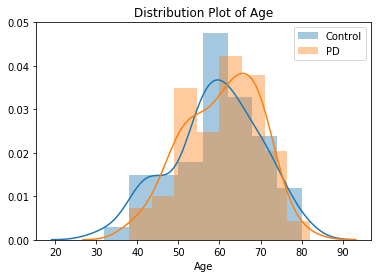

In [38]:
# seaborn distribution plot of Age
sns.distplot(df_control.Age, rug=False, label='Control')
sns.distplot(df_pd.Age, rug=False, label='PD')
plt.title('Distribution Plot of Age')
plt.legend()
plt.show() # pd has a slightly older distribution than control

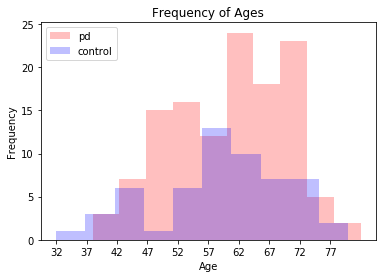

In [39]:
# plot for the ages
plt.hist(df_pd.Age, align='mid', alpha=0.25, color='r', label='pd', bins=10)
plt.hist(df_control.Age, align='mid', alpha=0.25, color='b', label='control', bins=10)
plt.legend(loc='upper left')

# set labels
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Frequency of Ages')

# set ticks
plt.xticks(np.arange(min(df_control.Age), max(df_control.Age)+1, 5.0))
plt.show()

No handles with labels found to put in legend.


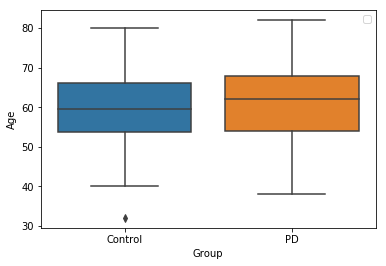

In [49]:
# some boxplots
sns.boxplot(x="Group", y="Age", data=patient_df)
plt.legend()
plt.xticks([0, 1], ['Control', 'PD'])

plt.show()

In [50]:
## Gender Distributions
print ("For Control:")
print (np.unique(df_control.Sex.values, return_counts=True))
print ("For PD")
print (np.unique(df_pd.Sex.values, return_counts=True)) # very visible from results males are more likely to get pd..

For Control:
(array(['F', 'M'], dtype=object), array([15, 41]))
For PD
(array(['F', 'M'], dtype=object), array([46, 79]))


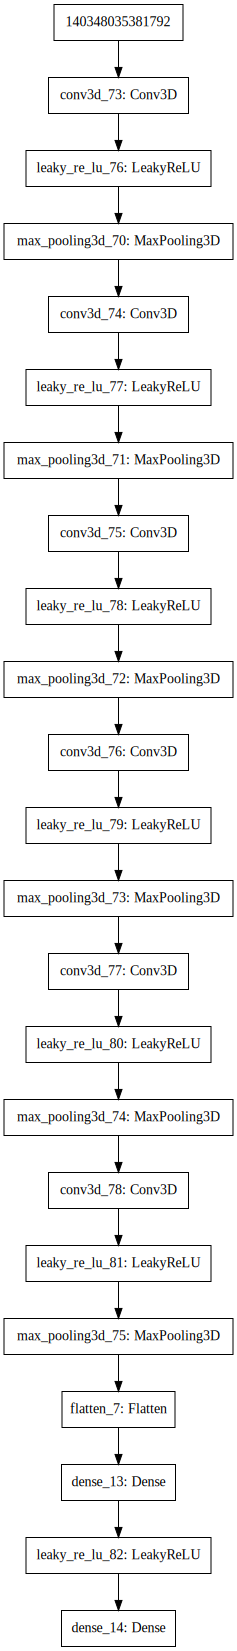

In [26]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Train on 64 samples, validate on 17 samples
Epoch 1/10
64/64 [==============================] - 7s 113ms/step - loss: 0.0202 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 1.0000
Epoch 2/10
64/64 [==============================] - 7s 111ms/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 1.0000
Epoch 3/10
64/64 [==============================] - 7s 111ms/step - loss: 0.0117 - acc: 1.0000 - val_loss: 0.0490 - val_acc: 1.0000
Epoch 4/10
64/64 [==============================] - 7s 111ms/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0442 - val_acc: 1.0000
Epoch 5/10
64/64 [==============================] - 7s 112ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 1.0000
Epoch 6/10
64/64 [==============================] - 7s 112ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.0472 - val_acc: 1.0000
Epoch 7/10
64/64 [==============================] - 7s 113ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.0492 - val_acc: 1.0000
Epoch 8/10
64/64 [==============

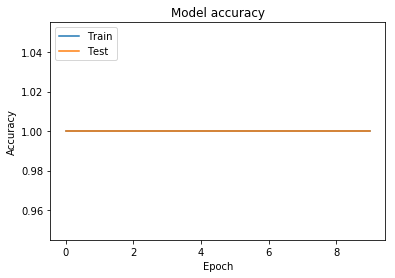

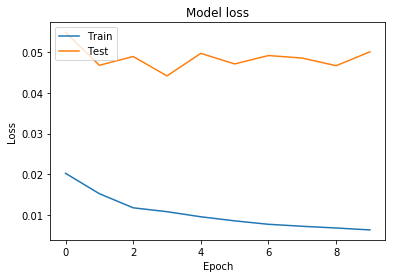

In [28]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=5, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Put into one super class which we can load our data (overwrite), fit and continue**

In [0]:
from keras.models import load_model
num_epochs = 3
batch_size = 10

batches_path = os.getcwd() + '/stored_batches'

for batch_pkl in os.listdir(batches_path):
  batch_pkl_path = batches_path + '/' + batch_pkl
  
  # load up the batch
  with open(batch_pkl_path, 'rb') as f:
    total_slices, total_slices_info = pickle.load(f)
    
  # get the corresponding y-values
  y_values = get_y_values(total_slices_info)
  
  # split into training and test set
  X_train, X_test, y_train, y_test = train_test_split(total_slices, y_values, test_size=0.2, shuffle=True)
  
  # fit to our existing model
  model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, # can modify batch size and epochs
          validation_data=(X_test, y_test), shuffle=True)

# creates a file and saves it (architecture, weights, optimizer)
model.save('my_model.h5', overwrite=True)  # creates a HDF5 file 'my_model.h5'
# model = load_model('my_model.h5')